<a href="https://colab.research.google.com/drive/19wnfyRu1HBqQSXVTZnOb-LRB0CsvRj3G?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2024 6.484 Computational Sensorimotor Learning Assignment 3

In this assignment, we will implement PPO and go through the reward design process when you use reinforcement learning algorithms to solve a task.

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are **195** total points to be had in this PSET, plus 10 bonus points for filling out the survey.  `ctrl-f` for "pts" to ensure you don't miss questions.

We strongly suggest using Colab Pro for this assignment. As mentioned in class up to 3 month of Google Colab Pro (30$) will be reimbursed.

In [1]:
!pip install pybullet > /dev/null 2>&1
!pip install git+https://github.com/idanshen/easyrl.git@sac > /dev/null 2>&1
!pip install "setuptools<58.0.0" > /dev/null 2>&1
!pip install git+https://github.com/Improbable-AI/airobot.git > /dev/null 2>&1
!pip install git+https://github.com/Farama-Foundation/Minigrid.git@gym-minigrid-legacy &>/dev/null

In [2]:
# You can enable the GPU by changing the runtime (Runtime -> Change runtime type -> Hardware accelerator -> GPU )
from typing import Tuple, List, Dict
import os
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import random
import gym
import pprint
import pybullet as p
import pybullet_data as py_d
import airobot as ar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pylab
from airobot import Robot
from airobot.utils.common import quat2euler
from airobot.utils.common import euler2quat
from gym import spaces
from gym.envs.registration import registry, register
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from torch import nn
from pathlib import Path
from easyrl.agents.ppo_agent import PPOAgent
from easyrl.configs import cfg
from easyrl.configs import set_config
from easyrl.configs.command_line import cfg_from_cmd
from easyrl.engine.ppo_engine import PPOEngine
from easyrl.models.categorical_policy import CategoricalPolicy
from easyrl.models.diag_gaussian_policy import DiagGaussianPolicy
from easyrl.models.mlp import MLP
from easyrl.models.value_net import ValueNet
from easyrl.runner.nstep_runner import EpisodicRunner
from easyrl.utils.common import set_random_seed
from easyrl.utils.gym_util import make_vec_env
from easyrl.utils.common import load_from_json
from base64 import b64encode
%matplotlib inline
%load_ext tensorboard
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


# Part 1: Implementing PPO [30 pts]

In this part you will solve the same environment from the previous assignment, this time with PPO. Run the following code cells to set up the same environment and model as the last pset.

In [3]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: dictionary or np.ndarray
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])

    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        super().__init__(size=5)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

In [4]:
class Config:
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=500,
                gae_lambda=0.95,
                use_critic=False,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=False):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.max_episodes = max_episodes # the maximum number of episodes.
        self.use_critic = use_critic # whether to use critic or not.
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.entropy_coef = entropy_coef # entropy coefficient for PPO
        self.use_gae = use_gae # whether to use GAE or not.

In [5]:
class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=False):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into expected order

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)

        return dist, value

def compute_discounted_return(rewards, discount, device=None):
    """
		rewards: reward obtained at timestep.  Shape: (T,)
		discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
		"""
    returns = torch.zeros(*rewards.shape, device=device)

    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    return returns

def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """
    advantages = torch.zeros_like(values)
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + args.discount * next_value  - values[i]
        advantages[i] = delta + args.discount * args.gae_lambda * next_advantage
    return advantages[:T]

def collect_experiences(env, acmodel, args, device=None):
    """Collects rollouts and computes advantages.
    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """


    MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP, )

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None]*MAX_FRAMES_PER_EP

    obs, _ = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)

        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action = dist.sample()[0]


        obss[T] = obs
        obs, reward, done, _, _ = env.step(action.item())


        # Update experiences values
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.log_prob(action)


        total_return += reward
        T += 1

        if done or T>=MAX_FRAMES_PER_EP-1:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)
    exps = dict(
        obs = preprocess_obss([
            obss[i]
            for i in range(T)
        ], device=device),
        action = actions[:T],
        value  = values[:T],
        reward = rewards[:T],
        advantage = discounted_reward-values[:T],
        log_prob = log_probs[:T],
        discounted_reward = discounted_reward,
        advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount)
    )

    logs = {
        "return_per_episode": total_return,
        "num_frames": T
    }

    return exps, logs

def run_experiment(args, parameter_update, seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    args: Config arguments. dict
    paramter_update: function used to update model parameters
    seed: random seed. int

    return: DataFrame indexed by episode
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = DoorKeyEnv5x5()

    acmodel = ACModel(env.action_space.n, use_critic=args.use_critic)
    acmodel.to(device)

    is_solved = False

    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW

    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))
    for update in pbar:
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"]}

        if args.use_critic:
            data['value_loss'] = logs["value_loss"]

        pd_logs.append(data)

        pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print('Solved!')

    return pd.DataFrame(pd_logs).set_index('episode')


# Proximal Policy Optimization

There are some surprisingly powerful additional tweaks we can make to our GAE implementation from the last pset to further improve performance.

The current standard in policy gradients today is [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347), which improves on GAE by taking multiply policy update steps per minibatch, enabled by policy update clipping (this is a specific variant called *PPO-Clip*).  This leads to greater sample efficiency, as larger steps can be taken from the same data samples.

We've implemented most of PPO for you: all that's left for you are the policy and value loss computations (note that you'll have to evaluate the `acmodel` each time you compute them).  Note that for the policy loss, we also ask that you return the approximate KL divergence between the new and old action distributions notated as `approx_kl`; this is used to facilitate an early stopping condition in policy updates. This [blog post](http://joschu.net/blog/kl-approx.html) shares a simple formula for approximating KL divergence that you can use.

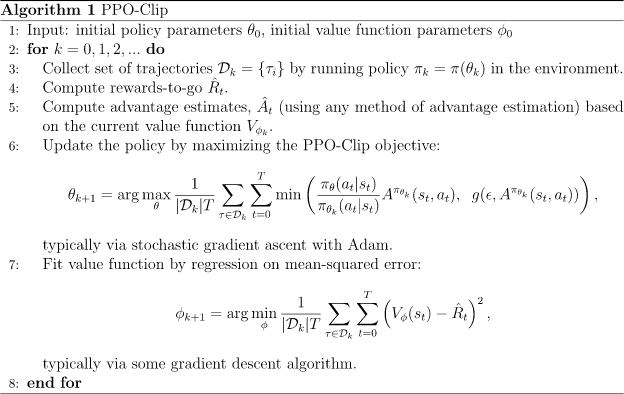

Where 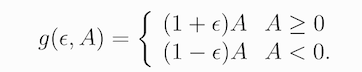

A commonly used technique is to add entropy regularization for policy gradient methods as shown in equation 9 of this paper. You should compute the policy loss as defined above and also add in an entropy term for the updated policy (note that we've provided to you an entropy coefficient in args.entropy_coef).

In [11]:
def update_parameters_ppo(optimizer, acmodel, sb, args):
    def _compute_policy_loss_ppo(obs, old_logp, actions, advantages):
        '''
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        '''
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######
        dist, _ = acmodel(obs)
        logp = dist.log_prob(actions)

        entropy = dist.entropy().mean()

        ratio = torch.exp(logp - old_logp)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - args.clip_ratio, 1.0 + args.clip_ratio) * advantages

        policy_loss = -torch.min(surr1, surr2).mean() - args.entropy_coef * entropy

        approx_kl = (old_logp - logp).mean()
        ##################################################################

        return policy_loss, approx_kl

    def _compute_value_loss(obs, returns):
        ### TODO: implement PPO value loss computation (10 pts) ##########
        value_loss = 0

        _, value = acmodel(obs)
        value_loss = ((value - returns) ** 2).mean()
        ##################################################################

        return value_loss


    dist, _ = acmodel(sb['obs'])
    old_logp = dist.log_prob(sb['action']).detach()

    advantage = sb['advantage_gae'] if args.use_gae else sb['advantage']

    policy_loss, _ = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
    value_loss = _compute_value_loss(sb['obs'], sb['discounted_reward'])

    for i in range(args.train_ac_iters):
        optimizer.zero_grad()
        loss_pi, approx_kl = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
        loss_v = _compute_value_loss(sb['obs'], sb['discounted_reward'])

        loss = loss_v + loss_pi
        if approx_kl > 1.5 * args.target_kl:
            break

        loss.backward(retain_graph=True)
        optimizer.step()

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
    }

    return logs

  0%|          | 0/500 [00:00<?, ?it/s]

Solved!


<Axes: xlabel='num_frames'>

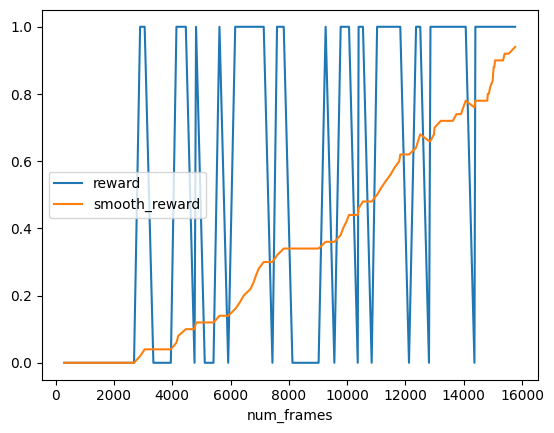

In [10]:
args = Config(use_critic=True, use_gae=True)
df_ppo = run_experiment(args, update_parameters_ppo)

df_ppo.plot(x='num_frames', y=['reward', 'smooth_reward'])

To help you observe more clearly the advantages of PPO compared to the previous algorithms, we include here the 'fancy plot' from the previous assignment, this time with PPO as well.

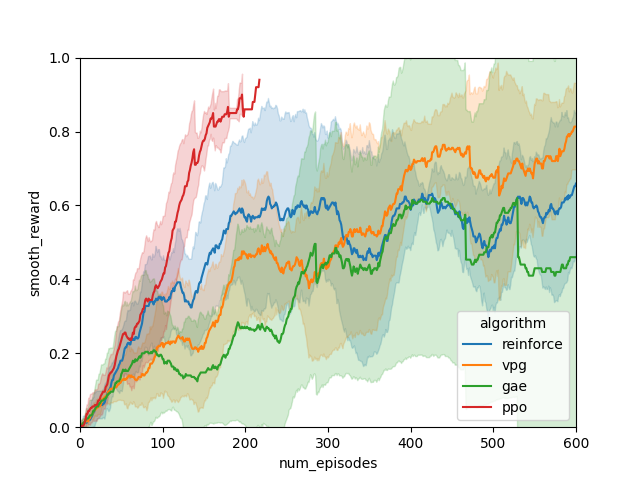

# Part 2: Reward Design
For part 2 of this assignment, you will design various rewards for a robotics task.

In [14]:
def play_video(video_dir: str, video_file: str = None) -> None:
    """
      Parameters:
      - video_dir (str): The directory path where video files are located. This is used if `video_file` is not provided.
      - video_file (str, optional): The path to a specific video file to play. If None, the function searches for
        'render_video.mp4' in `video_dir`.

      Returns:
        - None: This function does not return any value. It directly displays the video within the IPython notebook.
    """
    if video_file is None:
        video_dir = Path(video_dir)
        video_files = list(video_dir.glob(f'**/render_video.mp4'))
        video_files.sort()
        video_file = video_files[-1]
    else:
        video_file = Path(video_file)
    compressed_file = video_file.parent.joinpath('comp.mp4')
    os.system(f"ffmpeg -i {video_file} -filter:v 'setpts=2.0*PTS' -vcodec libx264 {compressed_file.as_posix()}")
    mp4 = open(compressed_file.as_posix(),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))


# read tf log file
def read_tf_log(log_dir: str) -> Tuple[List[int], List[float], List[float]]:
    """
        Parameters:
      - log_dir (str): The directory path where TensorFlow log files are located. The function searches for files
        starting with 'events.' within this directory and its subdirectories.

      Returns:
      - Tuple[List[int], List[float], List[float]]: A tuple containing three lists:
          - steps (List[int]): A list of steps at which each episode's success rate was recorded.
          - returns (List[float]): A list of mean returns for each episode.
          - success_rate (List[float]): A list of success rates for each episode.
        Returns None if no log files are found or if there's an error in extracting scalar values.
    """
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/events.*'))
    if len(log_files) < 1:
        return None
    log_file = log_files[0]
    event_acc = EventAccumulator(log_file.as_posix())
    event_acc.Reload()
    tags = event_acc.Tags()
    try:
        scalar_success = event_acc.Scalars('train/episode_success')
        success_rate = [x.value for x in scalar_success]
        steps = [x.step for x in scalar_success]
        scalar_return = event_acc.Scalars('train/episode_return/mean')
        returns = [x.value for x in scalar_return]
    except:
        return None
    return steps, returns, success_rate


def plot_curves(data_dict: Dict[str, List[List[float]]], title: str) -> None:
    """
        Parameters:
      - data_dict (Dict[str, List[List[float]]]): A dictionary where each key is a label string and each value is a list
        containing two lists: the first list for x-values and the second for y-values of the curve.
      - title (str): The title of the plot.

      This function does not return anything. It directly displays the plot.
    """
    fig, ax = plt.subplots(figsize=(4, 3))
    labels = data_dict.keys()
    for label, data in data_dict.items():
        x = data[0]
        y = data[1]
        ax.plot(x, y, label=label)
    ax.set_title(title)
    ax.legend()

def check_collision_rate(log_dir: str) -> float:
    """
        Parameters:
      - log_dir (str): The directory path where 'info.json' log files are stored. The function searches for files
        named 'info.json' within this directory and its subdirectories, and uses the most recent file based on sorting.

      Returns:
      - float: The average collision rate extracted from the log file.

    """
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/info.json'))
    log_files.sort()
    log_file = log_files[-1]
    info_data = load_from_json(log_file)
    collisions = [v['collision'] for k, v in info_data.items()]
    return np.mean(collisions)

# Environment

We will use [AIRobot](https://github.com/Improbable-AI/airobot/tree/master) for this assignment. The task here is to move the end-effector of a [UR robot](https://www.universal-robots.com/) from a fixed starting position (shown as the yellow ball in the figure below) to a fixed goal position (shown as the red ball in the figure below). The end-effector is constrained to move in $xy$-plane only (the horizontal plane).

**State**: the 2D position of the end-effector tip, $(x, y)$

**Action**: 2D continuous action space, $[\Delta x, \Delta y]$. The end-effector can move in $x$ direction by $\Delta x$, $y$ direction by $\Delta y$. We scale $\Delta x, \Delta y$ so that they are in the range of $[-1, 1]$.


The following figures visually show the robot environment:

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/1_1.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/1_2.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/1_3.png" height="300"></iframe>

The robot environment is defined in the following class (`URRobotGym`). Your task is to design and fill in the reward functions. You don't need to change other parts of the code in this class.

In [15]:
class URRobotGym(gym.Env):
    def __init__(self,
                 action_repeat: int = 10,
                 use_sparse_reward: bool = False,
                 use_subgoal: bool = False,
                 with_obstacle: bool = True,
                 apply_collision_penalty: bool = False,
                 # Set 'gui' to False if you are using Colab, otherwise the session will crash as Colab does not support X window
                 # You can set it to True for debugging purpose if you are running the notebook on a local machine.
                 gui: bool = False,
                 max_episode_length: int = 25,
                 dist_threshold: float = 0.05
                 ):
        """
          Initializes the URRobotGym environment.

          Parameters:
          - action_repeat (int): The number of times an action is repeated per step in the environment.
          - use_sparse_reward (bool): If True, use sparse rewards; otherwise, use dense rewards.
          - use_subgoal (bool): If True, include subgoals in the environment.
          - with_obstacle (bool): If True, include obstacles in the environment.
          - apply_collision_penalty (bool): If True, apply a penalty for collisions.
          - gui (bool): If False, run the environment without a GUI to prevent crashes in environments like Colab.
                        Set to True for debugging on local machines where a GUI is supported.
          - max_episode_length (int): The maximum length of an episode.
          - dist_threshold (float): The distance threshold to consider a goal achieved.

          Initializes the robot, sets up the environment with optional obstacles, subgoals, and visual markers,
          and configures the action and observation spaces.
        """
        self._action_repeat = action_repeat
        self._max_episode_length = max_episode_length
        self._dist_threshold = dist_threshold
        self._use_sparse_reward = use_sparse_reward
        self._use_subgoal = use_subgoal
        self._apply_collision_penalty = apply_collision_penalty
        self._with_obstacle = with_obstacle
        print(f'================================================')
        print(f'Use sparse reward:{self._use_sparse_reward}')
        print(f'Use subgoal:{self._use_subgoal}')
        print(f'With obstacle in the scene:{self._with_obstacle}')
        print(f'Apply collision penalty:{self._apply_collision_penalty}')
        print(f'================================================')

        self._xy_bounds = np.array([[0.23, 0.78],  # [xmin, xmax]
                                    [-0.35, 0.3]])  # [ymin, ymax]
        self.robot = Robot('ur5e_stick',
                           pb_cfg={'gui': gui,
                                   'realtime': False,
                                   'opengl_render': torch.cuda.is_available()})
        self._arm_reset_pos = np.array([-0.38337763,
                                        -2.02650575,
                                        -2.01989619,
                                        -0.64477803,
                                        1.571439041,
                                        -0.38331266])
        self._table_id = self.robot.pb_client.load_urdf('table/table.urdf',
                                                        [.5, 0, 0.4],
                                                        euler2quat([0, 0, np.pi / 2]),
                                                        scaling=0.9)

        # create a ball at the start location (for visualization purpose)
        self._start_pos = np.array([0.45, -0.32, 1.0])
        self._start_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                             base_pos=self._start_pos,
                                                             rgba=[1, 1, 0, 0.8])

        # create a ball at the goal location
        self._goal_pos = np.array([0.5, 0.26, 1.0])
        self._goal_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                            base_pos=self._goal_pos,
                                                            rgba=[1, 0, 0, 0.8])

        # disable the collision checking between the robot and the ball at the goal location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._goal_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)
        # disable the collision checking between the robot and the ball at the start location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._start_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)

        # create an obstacle
        if self._with_obstacle:
            self._wall_id = self.robot.pb_client.load_geom('box', size=[0.18, 0.01, 0.1], mass=0,
                                                           base_pos=[0.5, 0.15, 1.0],
                                                           rgba=[0.5, 0.5, 0.5, 0.8])

        # create balls at subgoal locations
        if self._use_subgoal:
            self._subgoal_pos = np.array([[0.24, 0.15, 1.0], [0.76, 0.15, 1.0]])
            self._subgoal_urdf_id = []
            for pos in self._subgoal_pos:
                self._subgoal_urdf_id.append(self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                                            base_pos=pos,
                                                                            rgba=[0, 0.8, 0.8, 0.8]))
            # disable the collision checking between the robot and the subgoal balls
            for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
                for sg in self._subgoal_urdf_id:
                    self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                                sg,
                                                                i,
                                                                -1,
                                                                enableCollision=0)

        self._action_bound = 1.0
        self._ee_pos_scale = 0.02
        self._action_high = np.array([self._action_bound] * 2)
        self.action_space = spaces.Box(low=-self._action_high,
                                       high=self._action_high,
                                       dtype=np.float32)
        state_low = np.full(len(self._get_obs()), -float('inf'))
        state_high = np.full(len(self._get_obs()), float('inf'))
        self.observation_space = spaces.Box(state_low,
                                            state_high,
                                            dtype=np.float32)
        self.reset()

    def reset(self) -> np.array:
        """
          Resets the environment to its initial state.

          Returns:
          - obs (np.ndarray): The initial observation of the environment after resetting.
        """
        self.robot.arm.set_jpos(self._arm_reset_pos, ignore_physics=True)
        self._t = 0
        self._ref_ee_pos = self.robot.arm.get_ee_pose()[0]
        self._ref_ee_ori = self.robot.arm.get_ee_pose()[1]
        return self._get_obs()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, dict]:
        """
          Parameters:
          - action (np.ndarray): The action to be executed

          Returns:
          - state (np.ndarray): The next state of the environment after executing the action.
          - reward (float): The reward received after executing the action.
          - done (bool): A flag indicating whether the episode has ended (True if the episode is done, False otherwise).
          - info (dict): Additional information such as whether a collision occurred.
        """
        ...
        collision = self._apply_action(action)
        self._t += 1
        state = self._get_obs()
        done = self._t >= self._max_episode_length
        reward, info = self._get_reward(state=state, action=action, collision=float(collision))
        info['collision'] = collision
        return state, reward, done, info

    def _get_reward(self, state: np.ndarray, action: np.ndarray, collision: float) -> Tuple[float, dict]:
        """
          Parameters:
          - state (np.ndarray): The current state of the environment.
          - action (np.ndarray): The action taken from the current state.
          - collision (float): A float indicating whether a collision occurred (1.0 if yes, 0.0 if no).

          Returns:
          - reward (float): The calculated reward
          - info (dict): A dictionary containing additional information about the reward calculation, including whether the goal was achieved (success flag).
        """
        dist_to_goal = np.linalg.norm(state - self._goal_pos[:2])
        success = dist_to_goal < self._dist_threshold
        if self._use_sparse_reward:
            #### TODO: Q1 design a sparse reward
            reward = 1.0 if success else 0.0

        elif self._use_subgoal:
            reward = self._get_reward_with_subgoal(state)
        else:
            #### TODO: Q2 design a dense reward based on only the state and the goal position (no other information)
            reward = -dist_to_goal

        if self._apply_collision_penalty:
            #### TODO: Q4 apply a collision penalty
            if collision:
                reward -= 5

        info = dict(success=success)
        return reward, info

    def _get_reward_with_subgoal(self, state: np.ndarray) -> float:
        """
          Parameters:
          - state (np.ndarray): The current state of the environment.

          Returns:
          - reward: The calculated reward based on the proximity to subgoals and the final goal.
        """
        #### TODO: Q5 design a reward based on the state, goal and subgoal positions
        if state[1] < self._subgoal_pos[0][1]:
            reward = max(-np.linalg.norm(self._goal_pos[:2] - self._subgoal_pos[0][:2]) - 1.5*np.linalg.norm(state - self._subgoal_pos[0][:2]), -np.linalg.norm(self._goal_pos[:2] - self._subgoal_pos[1][:2]) - 1.5*np.linalg.norm(state - self._subgoal_pos[1][:2]))
        else:
            reward = -1.5*np.linalg.norm(state - self._goal_pos[:2])
        return reward

    def _get_obs(self):
        """
          Returns:
          - state (np.ndarray): The current state observation, i.e., the x and y positions of the robot's end-effector.
        """
        gripper_pos = self.robot.arm.get_ee_pose()[0][:2]
        state = gripper_pos
        return state

    def _check_collision_with_wall(self):
        """
          Returns:
          - bool: True if a collision is detected, False otherwise.
        """
        if hasattr(self, '_wall_id'):
            return len(self.robot.pb_client.getContactPoints(self.robot.arm.robot_id,
                                                             self._wall_id, 10, -1)) > 0
        else:
            return False

    def _apply_action(self, action: np.ndarray) -> bool:
        """
          Parameters:
          - action (np.ndarray): The action to be executed.

          Returns:
          - bool: Indicates whether a collision occurred as a result of applying the action.

        """
        jnt_poses = self.robot.arm.get_jpos()
        if not isinstance(action, np.ndarray):
            action = np.array(action).flatten()
        if action.size != 2:
            raise ValueError('Action should be [d_x, d_y].')
        # we set dz=0
        action = np.append(action, 0)
        pos, quat, rot_mat, euler = self.robot.arm.get_ee_pose()
        pos += action[:3] * self._ee_pos_scale
        pos[2] = self._ref_ee_pos[2]
        # if the new position is out of the bounds, then we don't apply the action
        if not np.logical_and(np.all(pos[:2] >= self._xy_bounds[:, 0]),
                              np.all(pos[:2] <= self._xy_bounds[:, 1])):
            return False

        # move the end-effector to the new position
        jnt_pos = self.robot.arm.compute_ik(pos, ori=self._ref_ee_ori)
        for step in range(self._action_repeat):
            self.robot.arm.set_jpos(jnt_pos)
            self.robot.pb_client.stepSimulation()

        # if collision occurs, we reset the robot back to its original pose (before apply_action)
        collision = False
        if self._check_collision_with_wall():
            self.robot.arm.set_jpos(jnt_poses, ignore_physics=True)
            collision = True
        return collision


    def render(self, mode, **kwargs):
        """
          Renders the current state of the environment for visualization.

          Parameters:
          - mode (str): The mode for rendering. 'human' for on-screen rendering and potentially other modes
            for off-screen rendering or returning data arrays for further processing.

          Returns:
          - np.ndarray: An image array representing the current visual state of the environment, if applicable based on the rendering mode.

        """
        robot_base = self.robot.arm.robot_base_pos
        self.robot.cam.setup_camera(focus_pt=robot_base,
                                    dist=2,
                                    yaw=85,
                                    pitch=-20,
                                    roll=0)
        rgb, _ = self.robot.cam.get_images(get_rgb=True,
                                           get_depth=False)
        return rgb

    def seed(self, seed):
      return np.random.seed(seed)

module_name = __name__

env_name = 'URReacher-v1'
if env_name in registry:
    del registry[env_name]
register(
    id=env_name,
    entry_point=f'{module_name}:URRobotGym',
)

For this assignment, we will use PPO to train the policy. The training code is already complete. You don't need to modify any code here.

In [16]:
# DO NOT MODIFY THIS
def train_ppo(use_sparse_reward: bool = False, use_subgoal: bool = False, with_obstacle: bool = False,
              apply_collision_penalty: bool = False, push_exp: bool = False, max_steps: int = 200000) -> str:
    """
      Parameters:
      - use_sparse_reward (bool): Specifies whether to use sparse rewards in the environment.
      - use_subgoal (bool): Specifies whether to include subgoals in the environment.
      - with_obstacle (bool): Specifies whether to include obstacles in the environment.
      - apply_collision_penalty (bool): Specifies whether to apply a penalty for collisions.
      - push_exp (bool): Specifies whether to train on a pushing experiment. Changes the environment to 'URPusher-v1'.
      - max_steps (int): The maximum number of steps to train the agent.

      Returns:
      - str: The directory where training data and models are saved.
    """
    set_config('ppo')
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 100
    cfg.alg.max_steps = max_steps
    cfg.alg.deque_size = 20
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = 'URPusher-v1' if push_exp else 'URReacher-v1'
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += '/'
    if push_exp:
        cfg.alg.save_dir += 'push'
    else:
        cfg.alg.save_dir += 'sparse' if use_sparse_reward else 'dense'
        cfg.alg.save_dir += f'_ob_{str(with_obstacle)}'
        cfg.alg.save_dir += f'_sg_{str(use_subgoal)}'
        cfg.alg.save_dir += f'_col_{str(apply_collision_penalty)}'
    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'      Total number of steps:{cfg.alg.max_steps}')
    print(f'====================================')

    set_random_seed(cfg.alg.seed)
    env_kwargs=dict(use_sparse_reward=use_sparse_reward,
                    with_obstacle=with_obstacle,
                    use_subgoal=use_subgoal,
                    apply_collision_penalty=apply_collision_penalty) if not push_exp else dict()
    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed,
                       env_kwargs=env_kwargs)
    env.reset()
    ob_size = env.observation_space.shape[0]

    actor_body = MLP(input_size=ob_size,
                     hidden_sizes=[64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)

    critic_body = MLP(input_size=ob_size,
                     hidden_sizes=[64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)
    if isinstance(env.action_space, gym.spaces.Discrete):
        act_size = env.action_space.n
        actor = CategoricalPolicy(actor_body,
                                 in_features=64,
                                 action_dim=act_size)
    elif isinstance(env.action_space, gym.spaces.Box):
        act_size = env.action_space.shape[0]
        actor = DiagGaussianPolicy(actor_body,
                                   in_features=64,
                                   action_dim=act_size,
                                   tanh_on_dist=cfg.alg.tanh_on_dist,
                                   std_cond_in=cfg.alg.std_cond_in)
    else:
        raise TypeError(f'Unknown action space type: {env.action_space}')

    critic = ValueNet(critic_body, in_features=64)
    agent = PPOAgent(actor=actor, critic=critic, env=env)
    runner = EpisodicRunner(agent=agent, env=env)
    engine = PPOEngine(agent=agent,
                       runner=runner)
    engine.train()
    stat_info, raw_traj_info = engine.eval(render=False,
                                           save_eval_traj=True,
                                           eval_num=1,
                                           sleep_time=0.0)
    pprint.pprint(stat_info)
    return cfg.alg.save_dir


# Reaching Task without Obstacles

The first task we are going to solve is a reaching task without obstacles. We want to learn a policy that can move the robot's end-effector from the starting position to the goal position. And there is no obstacle in the scene.

## Sparse Reward

First, let's see if we can solve the reaching task by just using a sparse reward. The agent gets $+1$ reward if the end-effector tip is close to the goal position, $0$ reward otherwise.

$$r(s_t, a_t) = \begin{cases}1 \quad \text{if } \left\Vert s_t - s_g\right\Vert_2 < d_{thresh} \\ 0 \quad \text{otherwise}\end{cases}$$
where $s_g$ is the goal position, and $d_{thresh}$ is the distance threshold.

**Q1 [20 pts]**: Fill in the code for sparse reward (`use_sparse_reward=True`) in `_get_reward` function in URRobotGym. Train the policy with sparse reward, and plot the return curve and the success rate curve using the code below.

For experiments in this assignment, if you run them locally (not suggested), then you will see that a folder `data` is created in your current working directory. And you can run `tensorboard --logdir=data` to track the experiment progress (check `train/episode_success` and `train/episode_return/mean`). If you are using colab, the `data` folder will also be created, and you can download them during the training to check the learning curves locally.



In [25]:
#### Q1 (expected running time on T4 GPU: 7:30 min)
sparse_save_dir = train_ppo(use_sparse_reward=True, use_subgoal=False, with_obstacle=False, apply_collision_penalty=False)

[INFO][2024-03-11 17:49:10]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-11 17:49:10]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2024-03-11 17:49:10]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
      Total number of steps:200000
Use sparse reward:True
Use subgoal:False
With obstacle in the scene:False
Apply collision penalty:False


[ERROR][2024-03-11 17:49:12]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
[INFO][2024-03-11 17:49:12]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-11 17:49:12]: Saving checkpoint: /content/data/sparse_ob_False_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/sparse_ob_False_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-11 17:49:12]: Saving checkpoint: /content/data/sparse_ob_False_sg_False_col_False/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/sparse_ob_False_sg_False_col_False/seed_0/model/model_best.pt.
[INFO][2024-03-11 17:49:37]: Exploration steps: 10000
INFO:EasyRL:Exploration steps: 10000
[INFO][2024-03-11 17:49:37]: Saving checkpoint: /content/data/sparse_ob_False_sg_False_col_False/seed_0/model/ckpt_000000010000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/sp

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': 0.0,
 'eval/return/mean': 0.0,
 'eval/return/median': 0.0,
 'eval/return/min': 0.0,
 'eval/smooth_return/mean': 0.0,
 'eval/success': 0.0}


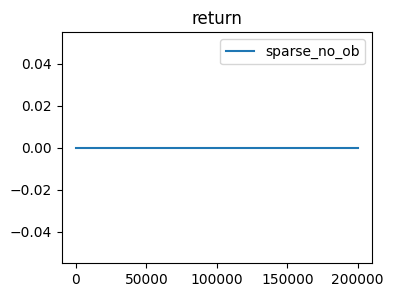

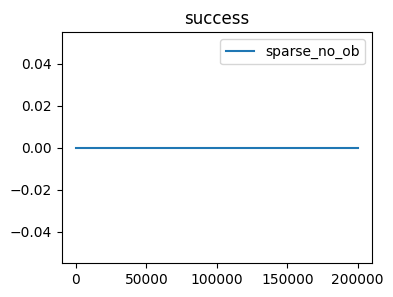

In [26]:
steps, returns, success_rate = read_tf_log(sparse_save_dir)
return_data = dict(
    sparse_no_ob=[steps, returns]
)
plot_curves(return_data, 'return')
success_data = dict(
    sparse_no_ob=[steps, success_rate]
)
plot_curves(success_data, 'success')

You can visually see what the robot is doing in the testing time by running `play_video(sparse_save_dir)`. You can use this function to check the trajectories of each policy you trained.

In [27]:
## assume the saving directory is `save_dir` (returned by `train_ppo`), then run:
# play_video(save_dir)
play_video(sparse_save_dir)

## Dense Reward

As we can see from the previous section, it is easy to specify a sparse reward. However, it makes the training much harder and the agent may fail to reach the goal. Can we provide a richer learning signal to the agent? One possibility is to provide a dense reward based on the distance between the current end-effector position and the goal position.

$$r(s_t, a_t) = -\left\Vert s_t - s_g\right\Vert_2$$


**Q2 [20 pts]**: Fill in the code for dense reward (`use_sparse_reward=False`), train the policy, and plot the return curve and the sucess rate curve.

In [28]:
#### Q2 (expected running time on T4 GPU: 9:00 min)
dense_save_dir = train_ppo(use_sparse_reward=False, use_subgoal=False, with_obstacle=False, apply_collision_penalty=False)

[INFO][2024-03-11 17:56:42]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-11 17:56:42]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2024-03-11 17:56:42]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
      Total number of steps:200000
Use sparse reward:False
Use subgoal:False
With obstacle in the scene:False
Apply collision penalty:False


[ERROR][2024-03-11 17:56:44]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
[INFO][2024-03-11 17:56:44]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-11 17:56:44]: Saving checkpoint: /content/data/dense_ob_False_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_False_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-11 17:56:44]: Saving checkpoint: /content/data/dense_ob_False_sg_False_col_False/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_False_sg_False_col_False/seed_0/model/model_best.pt.
[INFO][2024-03-11 17:57:11]: Exploration steps: 10000
INFO:EasyRL:Exploration steps: 10000
[INFO][2024-03-11 17:57:12]: Saving checkpoint: /content/data/dense_ob_False_sg_False_col_False/seed_0/model/ckpt_000000010000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_o

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': -1.4888358,
 'eval/return/mean': -1.4888358,
 'eval/return/median': -1.4888358,
 'eval/return/min': -1.4888358,
 'eval/smooth_return/mean': -1.4396754428327072,
 'eval/success': 1.0}


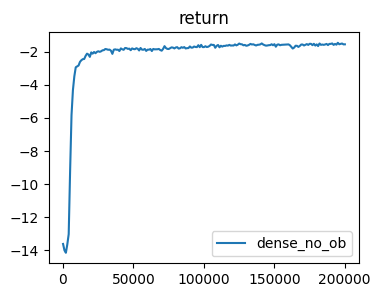

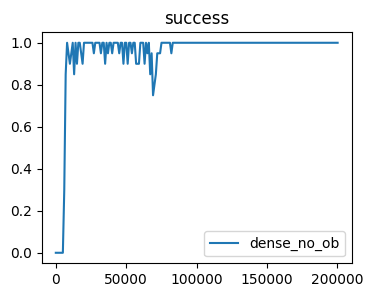

In [29]:
steps, returns, success_rate = read_tf_log(dense_save_dir)
return_data = dict(
    dense_no_ob=[steps, returns]
)
plot_curves(return_data, 'return')
success_data = dict(
    dense_no_ob=[steps, success_rate]
)
plot_curves(success_data, 'success')
play_video(dense_save_dir)

# Reaching Task with an Obstacle

Now that you can solve the reaching task without any obstacles in the environment. Let's make the task harder. What if there is a wall (obstacle) between the starting location and the goal location. The agent will need to learn to bypass the obstacle in order to reach the goal.

Now, the environment looks like this:

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/2_1.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/2_2.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/2_3.png" height="300"></iframe>

## Simple Dense Reward

As we have seen in the previous simpler task, using a sparse reward does not work. It's safe to say that using the sparse reward will not lead to success in this harder task either. So let's jump right into the dense reward case. Let's use the distance reward that is used in the previous section and try it on this task.

**Q3 [20 pts]**: Fill in the code for dense reward when there is an obstacle (`use_sparse_reward=False, with_obstacle=True`), train the policy, and plot the return curve and the sucess rate curve.

In [10]:
#### Q3 (expected running time on T4 GPU: 11:00 min)
obs_dense_save_dir = train_ppo(use_sparse_reward=False, use_subgoal=False, with_obstacle=True, apply_collision_penalty=False)

[INFO][2024-03-11 18:24:32]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-11 18:24:32]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2024-03-11 18:24:32]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
      Total number of steps:200000
Use sparse reward:False
Use subgoal:False
With obstacle in the scene:True
Apply collision penalty:False


[ERROR][2024-03-11 18:24:35]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
[INFO][2024-03-11 18:24:35]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-11 18:24:35]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-11 18:24:35]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_False/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_False_col_False/seed_0/model/model_best.pt.
[INFO][2024-03-11 18:25:06]: Exploration steps: 10000
INFO:EasyRL:Exploration steps: 10000
[INFO][2024-03-11 18:25:06]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_False/seed_0/model/ckpt_000000010000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_Tru

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': -4.204511,
 'eval/return/mean': -4.204511,
 'eval/return/median': -4.204511,
 'eval/return/min': -4.204511,
 'eval/smooth_return/mean': -4.329435416620877,
 'eval/success': 0.0}


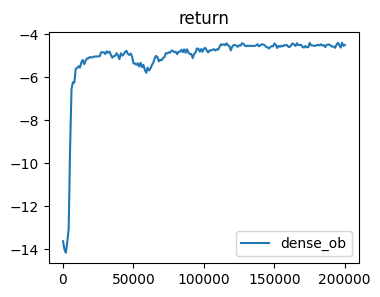

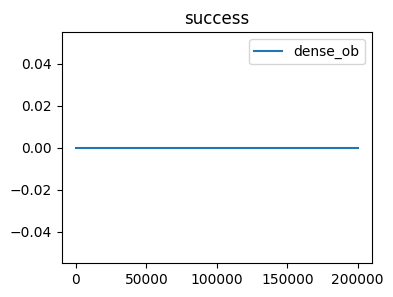

In [11]:
steps, returns, success_rate = read_tf_log(obs_dense_save_dir)
return_data = dict(
    dense_ob=[steps, returns]
)
plot_curves(return_data, 'return')
success_data = dict(
    dense_ob=[steps, success_rate]
)
plot_curves(success_data, 'success')
play_video(obs_dense_save_dir)

## Avoid the obstacle

As we can see that using a dense reward based on the distance between the current end-effector position and the goal position does not solve the task sucessfully. What's even worse is that the end-effector is hitting the wall repeatedly. This can cause safety issues on a real robot. Idealy, we don't want the robot to hit the obstacles.

**Q4 [30 pts]**

**Q4.1 [5 pts]**: Let's first check the collision rate ($\frac{\text{# of steps in collision}}{\text{total # of episode steps}}$) of the policy learned in the previous case. We have saved the testing results in `data/`, all we need to do is just read out the collision information from the saved data. We have provided you with the utility function `check_collision_rate`. What's the collsion rate for the policy you trained with the simple dense reward?

In [23]:
#### TODO
print(check_collision_rate('data/dense_ob_True_sg_False_col_False'))

0.84


Now we want to train the robot to avoid the obstacle. A simple way to achieve this is to give the agent some penalty when it collides with the obstacle.

**Q4.2 [20 pts]**: Apply the collision penalty when computing the reward value. Let's give $-5$ as the additional penalty whenever the agent hits the obstacle. Train the policy, and plot the return curve and the sucess rate curve.

In [24]:
#### Q4 (expected running time on T4 GPU: 10:00 min)
obs_colli_dense_save_dir = train_ppo(use_sparse_reward=False, use_subgoal=False, with_obstacle=True, apply_collision_penalty=True)

[INFO][2024-03-11 18:48:12]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-11 18:48:12]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2024-03-11 18:48:12]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
      Total number of steps:200000
Use sparse reward:False
Use subgoal:False
With obstacle in the scene:True
Apply collision penalty:True


[ERROR][2024-03-11 18:48:14]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
[INFO][2024-03-11 18:48:14]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-11 18:48:14]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-11 18:48:14]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/model_best.pt.
[INFO][2024-03-11 18:48:46]: Exploration steps: 10000
INFO:EasyRL:Exploration steps: 10000
[INFO][2024-03-11 18:48:46]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/ckpt_000000010000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': -8.0379305,
 'eval/return/mean': -8.0379305,
 'eval/return/median': -8.0379305,
 'eval/return/min': -8.0379305,
 'eval/smooth_return/mean': -8.004836266332196,
 'eval/success': 0.0}


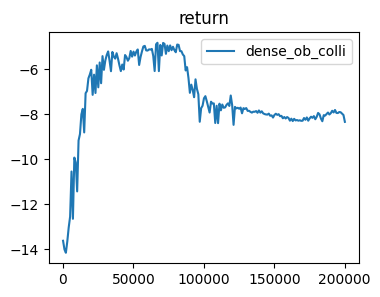

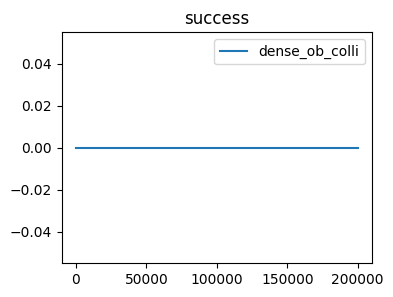

In [25]:
steps, returns, success_rate = read_tf_log(obs_colli_dense_save_dir)
return_data = dict(
    dense_ob_colli=[steps, returns]
)
plot_curves(return_data, 'return')
success_data = dict(
    dense_ob_colli=[steps, success_rate]
)
plot_curves(success_data, 'success')
play_video(obs_colli_dense_save_dir)

**Q4.3 [5 pts]** What's the collision rate now?

In [26]:
#### TODO
print(check_collision_rate('data/dense_ob_True_sg_False_col_True'))

0.0


## Dense reward with subgoals

As we can see in the previous section, if we add a collision penalty to the reward function, the agent can learn not to collide with the obstacle. However, it is still unable to reach the goal position as it gets stuck on the left side of the wall and never gets a chance to bypass it. We would need to design a better reward function.

Let's assume that we know two subgoal locations in the scene (shown as the light blue ball in the figures below). They are on the two sides of the obstacle. Can we use these two subgoal locations to design a better reward function such that the robot can finally reach the goal location?

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_1.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_2.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_3.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_4.png" height="300"></iframe>

**Q5 [30 pts]**: Can you come up with a reward function with the subgoal information (`use_subgoal=True`) and make the robot reach the goal location? Write down the reward function $r(s_t, a_t)$ mathematically. Same as before, train the policy and plot the return curve and the success rate curve. What's the collision rate in this case?

**A**:
$$r(s_t, a_t)=\max{(-\lVert s_g-s_{sg1}\rVert_2 - 1.5*\lVert s-s_{sg1}\rVert_2, -\lVert s_g-s_{sg2}\rVert_2 - 1.5*\lVert s-s_{sg2}\rVert_2)} \:\:\: \text{if}\:\:\: s[1] < s_{sg}[1]$$

$$r(s_t, a_t) = -1.5*\lVert s-s_g\rVert_2 \:\:\: \text{if}\:\:\: s[1] >= s_{sg}[1] $$


**note: Max function is needed to use either left or right subgoal. The distance between the state and goal in the first line and the distance between the state and goal in second line are scaled by 1.5 for better training**


Open-ended. For our solution, until we pass the plane of the wall we use the distance from the goal to subgoal + current position to subgoal. Other possibilities could include getting to the closest subgoal and then to the goal afterwards. Should see success curve reaching ~0.8.

In [35]:
#### Q5 (expected running time on T4 GPU: 9:00 min)
obs_colli_subgoal_dense_save_dir = train_ppo(use_sparse_reward=False, use_subgoal=True, with_obstacle=True, apply_collision_penalty=True)

[INFO][2024-03-11 21:26:07]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-11 21:26:07]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2024-03-11 21:26:07]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
      Total number of steps:200000
Use sparse reward:False
Use subgoal:True
With obstacle in the scene:True
Apply collision penalty:True


[ERROR][2024-03-11 21:26:09]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
[INFO][2024-03-11 21:26:09]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-11 21:26:09]: Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-11 21:26:09]: Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/model_best.pt.
[INFO][2024-03-11 21:26:38]: Exploration steps: 10000
INFO:EasyRL:Exploration steps: 10000
[INFO][2024-03-11 21:26:38]: Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/ckpt_000000010000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/dense_ob_True_sg_True_

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': -4.6144404,
 'eval/return/mean': -4.6144404,
 'eval/return/median': -4.6144404,
 'eval/return/min': -4.6144404,
 'eval/smooth_return/mean': -4.786765335491788,
 'eval/success': 1.0}


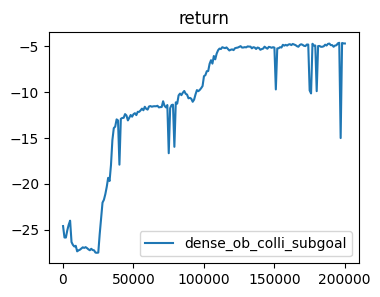

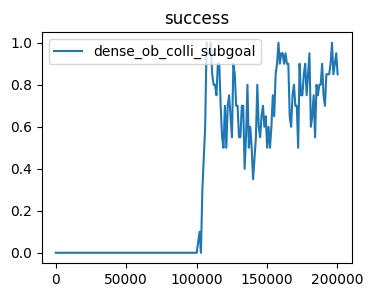

In [36]:
steps, returns, success_rate = read_tf_log(obs_colli_subgoal_dense_save_dir)
return_data = dict(
    dense_ob_colli_subgoal=[steps, returns]
)
plot_curves(return_data, 'return')
success_data = dict(
    dense_ob_colli_subgoal=[steps, success_rate]
)
plot_curves(success_data, 'success')
play_video(obs_colli_subgoal_dense_save_dir)

In [37]:
#### TODO: check collision rate for this run
print(check_collision_rate('data/dense_ob_True_sg_True_col_True'))

0.0


# Pushing Task

Now that you can solve the reaching task, let's try another harder task. We would like our robot to push a box (the pink object shown in the figure below) on the table from its initial position to a goal position (the red ball in the figure).

**State**: $[x_e, y_e, x_o, y_o]$, where $[x_e, y_e]$ is the 2D position of the end-effector tip, $[x_o, y_o]$ is the 2D position of the box.

**Action**: same as before.

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/4_1.png"  height="300"></iframe>

In [60]:
class URRobotPusherGym(gym.Env):
    def __init__(self,
                 action_repeat: int = 10,
                 gui: bool = False,
                 max_episode_length: int = 25,
                 dist_threshold:float = 0.05):
        """
          Parameters:
          - action_repeat (int): The number of times an action is repeated per step in the environment.
          - gui (bool): If False, run the environment without a GUI to prevent crashes in environments like Colab.
                        Set to True for debugging on local machines where a GUI is supported.
          - max_episode_length (int): The maximum length of an episode.
          - dist_threshold (float): The distance threshold to consider a goal achieved.
        """
        self._action_repeat = action_repeat
        self._max_episode_length = max_episode_length
        self._dist_threshold = dist_threshold

        self._xy_bounds = np.array([[0.23, 0.78],  # [xmin, xmax]
                                    [-0.35, 0.3]])  # [ymin, ymax]
        self.robot = Robot('ur5e_stick',
                           pb_cfg={'gui': gui,
                                   'realtime': False,
                                   'opengl_render': torch.cuda.is_available()})
        self._arm_reset_pos = np.array([-0.38337763,
                                        -2.02650575,
                                        -2.01989619,
                                        -0.64477803,
                                        1.571439041,
                                        -0.38331266])
        self._table_id = self.robot.pb_client.load_urdf('table/table.urdf',
                                                        [.5, 0, 0.4],
                                                        euler2quat([0, 0, np.pi / 2]),
                                                        scaling=0.9)

        # create a ball at the start location (for visualization purpose)
        self._start_pos = np.array([0.45, -0.32, 1.0])
        self._start_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                             base_pos=self._start_pos,
                                                             rgba=[1, 1, 0, 0.8])

        # create a ball at the goal location
        self._goal_pos = np.array([0.5, 0.2, 1.0])
        self._goal_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                            base_pos=self._goal_pos,
                                                            rgba=[1, 0, 0, 0.8])

        # disable the collision checking between the robot and the ball at the goal location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._goal_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)
        # disable the collision checking between the robot and the ball at the start location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._start_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)

        self._box_pos = np.array([0.35, -0.1, 0.996])
        self._box_id = self.robot.pb_client.load_geom('cylinder', size=[0.05, 0.05], mass=1.,
                                                      base_pos=self._box_pos,
                                                      rgba=[1., 0.6, 0.6, 1])

        self.robot.pb_client.changeDynamics(self._box_id, -1, lateralFriction=0.9)

        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._start_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)
        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._goal_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)

        self._action_bound = 1.0
        self._ee_pos_scale = 0.02
        self._action_high = np.array([self._action_bound] * 2)
        self.action_space = spaces.Box(low=-self._action_high,
                                       high=self._action_high,
                                       dtype=np.float32)
        state_low = np.full(len(self._get_obs()), -float('inf'))
        state_high = np.full(len(self._get_obs()), float('inf'))
        self.observation_space = spaces.Box(state_low,
                                            state_high,
                                            dtype=np.float32)
        self.reset()

    def reset(self) -> np.array:
        """
          Resets the environment to its initial state.

          Returns:
          - np.array: The initial observation of the environment after resetting.
        """
        self.robot.arm.set_jpos(self._arm_reset_pos, ignore_physics=True)
        self.robot.pb_client.reset_body(self._box_id, base_pos=self._box_pos)
        self._t = 0
        self._ref_ee_pos = self.robot.arm.get_ee_pose()[0]
        self._ref_ee_ori = self.robot.arm.get_ee_pose()[1]
        return self._get_obs()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, dict]:
        """
          Parameters:
          - action (np.ndarray): The action to be executed

          Returns:
          - state: The next state of the environment after executing the action.
          - reward: The reward received after executing the action.
          - done: A flag indicating whether the episode has ended (True if the episode is done, False otherwise).
          - info: Additional information such as whether a collision occurred.
        """
        previous_state = self._get_obs()
        collision = self._apply_action(action)
        self._t += 1
        state = self._get_obs()
        done = self._t >= self._max_episode_length
        reward, info = self._get_reward(state=state, action=action, previous_state=previous_state)
        info['collision'] = collision
        return state, reward, done, info

    def _get_reward(self, state: np.ndarray, action: np.ndarray, previous_state: np.ndarray) -> Tuple[float, dict]:
        """
          Parameters:
          - state (np.ndarray): The current state of the environment.
          - action (np.ndarray): The action taken from the current state.
          - previous_state (np.ndarray): The state of the environment in the previous time step.

          Returns:
          - reward: The calculated reward
          - info: A dictionary containing additional information about the reward calculation, including whether the goal was achieved (success flag).
        """
        object_pos = state[2:4]
        dist_to_goal = np.linalg.norm(object_pos - self._goal_pos[:2])
        success = dist_to_goal < self._dist_threshold
        #### TODO: Q6 design the reward given state, action, and previous state

        reward = -dist_to_goal #-np.linalg.norm(action)
        reward -= np.linalg.norm(state[:2]-state[2:4])

        reward += 1.5*(np.linalg.norm(previous_state[:2]-state[2:4]) - np.linalg.norm(state[:2]-state[2:4]))

        if success:
            reward += 1.0
        ####

        info = dict(success=success)
        return reward, info

    def _get_obs(self):
        """
          Returns:
          - np.ndarray: The current state observation, i.e., the x and y positions of the robot's end-effector.
        """
        gripper_pos = self.robot.arm.get_ee_pose()[0][:2]
        object_pos, object_quat = self.robot.pb_client.get_body_state(self._box_id)[:2]
        state = np.concatenate([gripper_pos, object_pos[:2]])
        return state

    def _apply_action(self, action: np.ndarray) -> bool:
        """
          Parameters:
          - action (np.ndarray): The action to be executed.

          Returns:
          - bool: Indicates whether a collision occurred as a result of applying the action.
        """
        if not isinstance(action, np.ndarray):
            action = np.array(action).flatten()
        if action.size != 2:
            raise ValueError('Action should be [d_x, d_y].')
        # we set dz=0
        action = np.append(action, 0)
        pos, quat, rot_mat, euler = self.robot.arm.get_ee_pose()
        pos += action[:3] * self._ee_pos_scale
        pos[2] = self._ref_ee_pos[2]
        # if the new position is out of the bounds, then we don't apply the action
        if not np.logical_and(np.all(pos[:2] >= self._xy_bounds[:, 0]),
                              np.all(pos[:2] <= self._xy_bounds[:, 1])):
            return False

        # move the end-effector to the new position
        jnt_pos = self.robot.arm.compute_ik(pos, ori=self._ref_ee_ori)
        for step in range(self._action_repeat):
            self.robot.arm.set_jpos(jnt_pos)
            self.robot.pb_client.stepSimulation()

        return False

    def render(self, mode, **kwargs):
        """
          Renders the current state of the environment for visualization.

          Parameters:
          - mode (str): The mode for rendering. 'human' for on-screen rendering and potentially other modes
            for off-screen rendering or returning data arrays for further processing.

          Returns:
          - np.ndarray: An image array representing the current visual state of the environment, if applicable based on the rendering mode.
        """
        robot_base = self.robot.arm.robot_base_pos
        self.robot.cam.setup_camera(focus_pt=robot_base,
                                    dist=2,
                                    yaw=85,
                                    pitch=-20,
                                    roll=0)
        rgb, _ = self.robot.cam.get_images(get_rgb=True,
                                           get_depth=False)
        return rgb

    def seed(self, seed):
      return np.random.seed(seed)




module_name = __name__

env_name = 'URPusher-v1'
if env_name in registry:
    del registry[env_name]
register(
    id=env_name,
    entry_point=f'{module_name}:URRobotPusherGym',
)

**Q6 [40 pts]**: Can you design a reward function so that the robot can push the box to the goal position? Write down the reward function $r(s_t, a_t)$ mathematically. Same as before, train the policy and plot the return curve and the success rate curve. If the reward function is good, you will see that the success rate will be at least above $0.8$ for a continued period of time. **HINTS**: If you use the negative of the distance between the object and the goal location as the reward function, does it work? What if you add another term to encourage the gripper to be close to the object? If the policy still does not learn, what other reward shaping terms are helpful for the training? The information you can use include the state before and after the robot executes the action, the action that the robot takes, the radius of the object is 0.05m, the radius of the end-effector stick is about $0.02\sim0.03$m.

**A**:
$$r(s_t, a_t)= -\lVert s_{\text{obj}} - s_g\rVert_2 - \lVert s_{\text{obj}} - s_{\text{gripper}}\rVert_2 + 1.5*(\lVert s_{\text{obj, prev}}-s_{g}\rVert_2 - \lVert s_{\text{obj}}-s_{g}\rVert_2)$$
$$r(s_t, a_t) \leftarrow r(s_t, a_t)+1 \:\:\: \text{if} \:\: \lVert s_{\text{obj}} - s_{\text{gripper}}\rVert_2 < \text{threshold} $$

**note: The difference in two distances: distance between the goal and the previous state and that between the goal and the current state (3rd term in the 1st line) is added to improve the training. 1.5 scaling is also added to improve training. Finally, the reward will have additional +1 if it reaches the success condition**

In [61]:
#### Q6 (expected running time on T4 GPU: 25:00 min)
# you can reduce the number of steps for debugging purpose
# but for the submission, you should run the experiment for at least 350000 steps!
push_save_dir = train_ppo(push_exp=True, max_steps=350000)

[INFO][2024-03-12 03:27:58]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
INFO:EasyRL:Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2024-03-12 03:27:58]: Creating 1 environments.
INFO:EasyRL:Creating 1 environments.
[INFO][2024-03-12 03:27:58]: Load in OpenGL!
INFO:AIRobot:Load in OpenGL!


      Device:cuda
      Total number of steps:350000


[ERROR][2024-03-12 03:28:00]: Not a valid git repo: /usr/local/lib/python3.10/dist-packages
ERROR:EasyRL:Not a valid git repo: /usr/local/lib/python3.10/dist-packages
[INFO][2024-03-12 03:28:00]: Exploration steps: 0
INFO:EasyRL:Exploration steps: 0
[INFO][2024-03-12 03:28:00]: Saving checkpoint: /content/data/push/seed_0/model/ckpt_000000000000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/push/seed_0/model/ckpt_000000000000.pt.
[INFO][2024-03-12 03:28:00]: Saving checkpoint: /content/data/push/seed_0/model/model_best.pt.
INFO:EasyRL:Saving checkpoint: /content/data/push/seed_0/model/model_best.pt.
[INFO][2024-03-12 03:28:32]: Exploration steps: 10000
INFO:EasyRL:Exploration steps: 10000
[INFO][2024-03-12 03:28:32]: Saving checkpoint: /content/data/push/seed_0/model/ckpt_000000010000.pt.
INFO:EasyRL:Saving checkpoint: /content/data/push/seed_0/model/ckpt_000000010000.pt.
[INFO][2024-03-12 03:28:32]: Saving checkpoint: /content/data/push/seed_0/model/model_best.pt.
INFO:EasyRL:Savin

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': 14.897495,
 'eval/return/mean': 14.897495,
 'eval/return/median': 14.897495,
 'eval/return/min': 14.897495,
 'eval/smooth_return/mean': 14.664087893695784,
 'eval/success': 1.0}


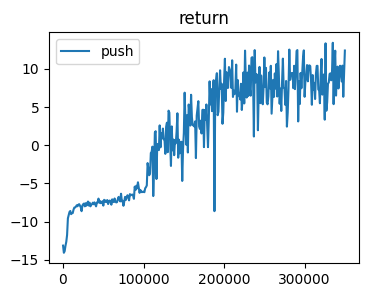

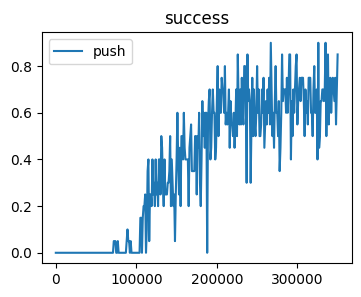

In [62]:
steps, returns, success_rate = read_tf_log(push_save_dir)
return_data = dict(
    push=[steps, returns]
)
plot_curves(return_data, 'return')
success_data = dict(
    push=[steps, success_rate]
)
plot_curves(success_data, 'success')
play_video(push_save_dir)

# Feedback Survey (optional)

Please enter the bonus code you get after filling out the [anonymous assignment survey](https://forms.gle/ojDvoPAwiKTRym969). (10 pts).

**Bonus code**: policy_gradient